In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from prophet import Prophet
import kaggle

In [2]:
def download_kaggle_dataset(kaggle_dataset: str ="pratyushakar/rossmann-store-sales") -> None:
    api = kaggle.api
    print(api.get_config_value('username'))
    kaggle.api.dataset_download_files(kaggle_dataset, path="./", unzip=True, quiet=False)
    
def prep_store_data(df: pd.DataFrame, store_id: int = 4, store_open: int = 1) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns= {'Date': 'ds', 'Sales': 'y'}, inplace=True)
    df_store = df[
        (df['Store'] == store_id) &\
        (df['Open'] == store_open)
    ].reset_index(drop=True)
    return df_store.sort_values('ds', ascending=True)   
    
def plot_store_data(df: pd.DataFrame) -> None:
    plt.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(figsize=(20,10))
    df.plot(x='ds', y='y', ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.legend(['Truth'])
    current_ytick_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])
    plt.savefig('store_data.png')
    

        
def train_predict(
    df: pd.DataFrame, 
    train_fraction: float, 
    seasonality: dict
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, int]:
    
    # grab split data
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict
    model.fit(df_train)
    predicted = model.predict(df_test)
    return predicted, df_train, df_test, train_index


def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20,10))
    df_test.plot(
        x='ds', 
        y='y', 
        ax=ax, 
        label='Truth', 
        linewidth=1, 
        markersize=5, 
        color='tab:blue',
        alpha=0.9, 
        marker='o'
    )
    predicted.plot(
        x='ds', 
        y='yhat', 
        ax=ax, 
        label='Prediction + 95% CI', 
        linewidth=2, 
        markersize=5, 
        color='red'
    )
    ax.fill_between(
        x=predicted['ds'], 
        y1=predicted['yhat_upper'], 
        y2=predicted['yhat_lower'], 
        alpha=0.15, 
        color='red',
    )
    df_train.iloc[train_index-100:].plot(
        x='ds', 
        y='y', 
        ax=ax, 
        color='tab:blue', 
        label='_nolegend_', 
        alpha=0.5, 
        marker='o'
    )
    current_ytick_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.tight_layout()
    plt.savefig('store_data_forecast.png')


opukaed


100%|██████████| 6.90M/6.90M [00:03<00:00, 1.93MB/s]


/tmp/ipykernel_3981/166472236.py:13: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4nusfibq/bxqa9dkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4nusfibq/klv2c8oq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/ed/.local/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43089', 'data', 'file=/tmp/tmp4nusfibq/bxqa9dkx.json', 'init=/tmp/tmp4nusfibq/klv2c8oq.json', 'output', 'file=/tmp/tmp4nusfibq/prophet_model88z05w7z/prophet_model-20240120034524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:45:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/home/ed/.local/lib/python3.10/site-packages/pandas/plotting/_matplotl

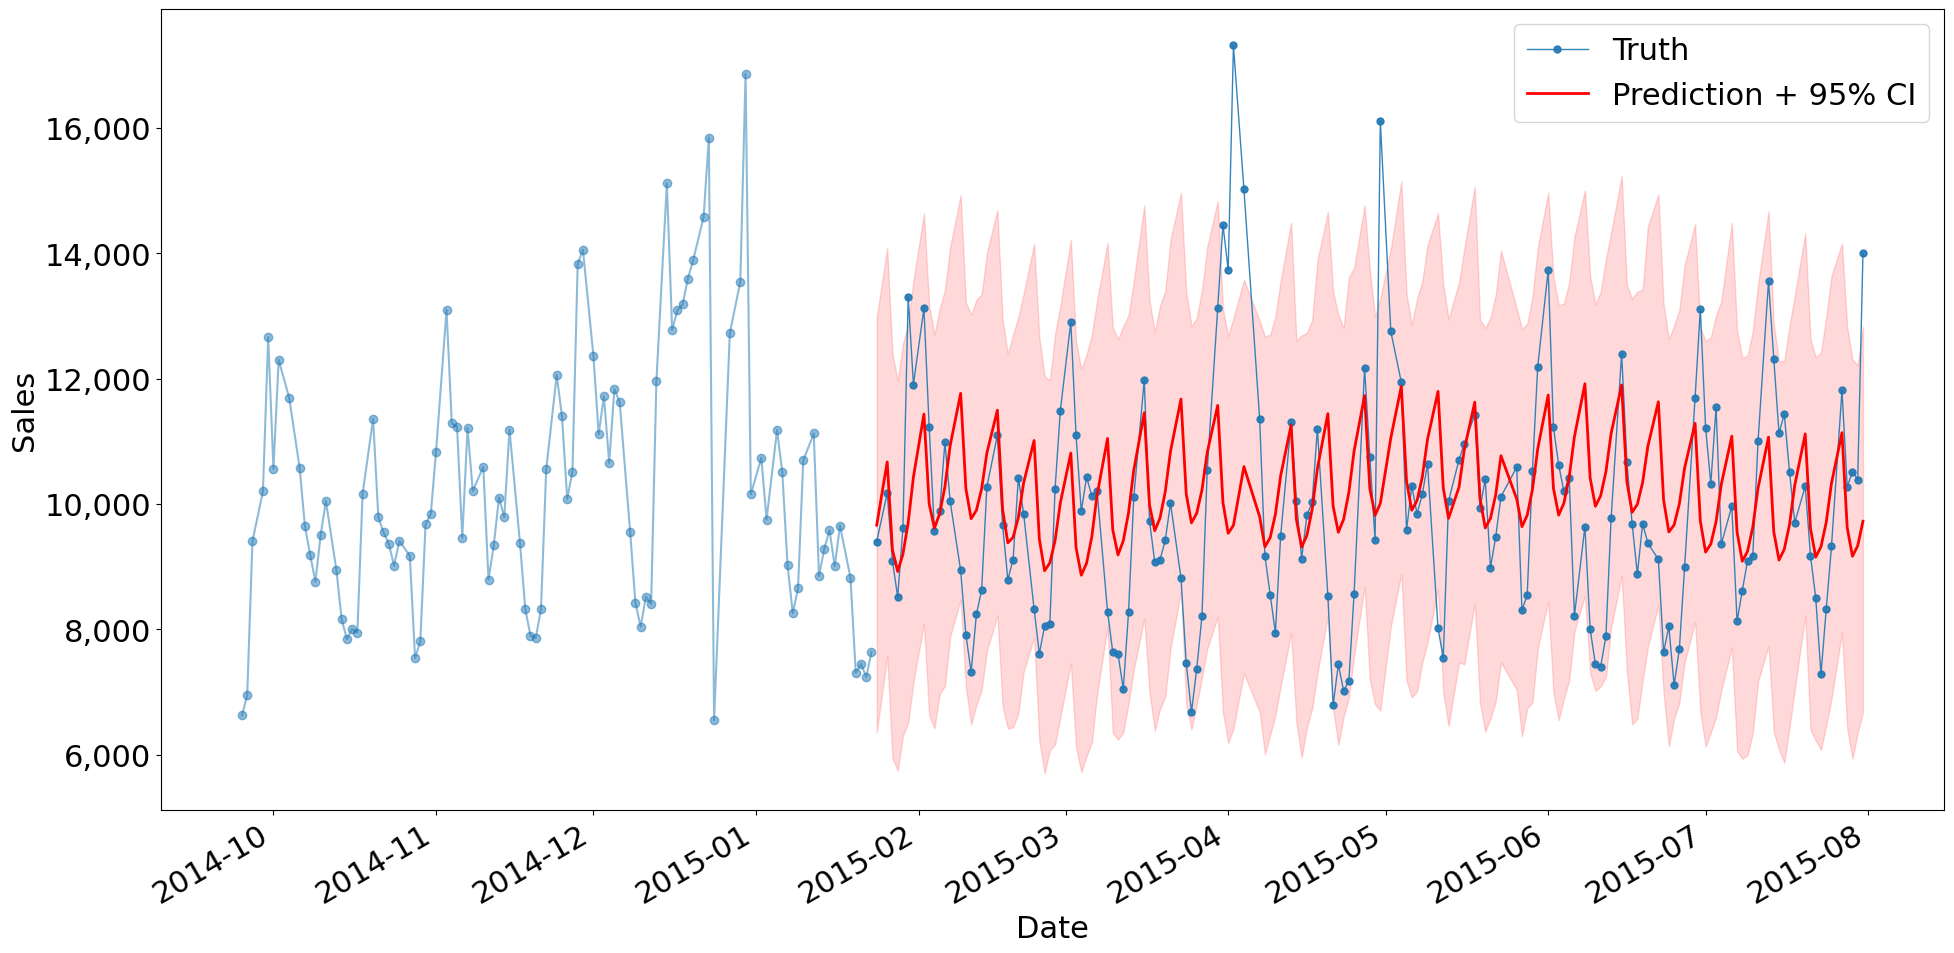

In [3]:
if __name__ == "__main__":
    import os
    
    # If data present, read it in, otherwise, download it 
    file_path = './train.csv'
    if os.path.exists(file_path):
        logging.info('Dataset found, reading into pandas dataframe.')
        df = pd.read_csv(file_path)
    else:
        logging.info('Dataset not found, downloading ...')
        download_kaggle_dataset()
        logging.info('Reading dataset into pandas dataframe.')
        df = pd.read_csv(file_path)   
    
    # Transform dataset in preparation for feeding to Prophet
    df = prep_store_data(df)
    
    # Define main parameters for modelling
    seasonality = {
        'yearly': True,
        'weekly': True,
        'daily': False
    }
    
    # Calculate the relevant dataframes
    predicted, df_train, df_test, train_index = train_predict(
        df = df,
        train_fraction = 0.8,
        seasonality=seasonality
    )
    
    # Plot the forecast
    plot_forecast(df_train, df_test, predicted)
        
    


